# Cobertura del intervalo de confianza para Poisson

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, chi2, gamma

Para todo lo siguiente, fijamos el nivel de confianza (CL) en el equivalente a $1\sigma$ de la gaussiana.

In [8]:
# Confidence Level
n_sigma = 1
CL = chi2(df=1).cdf(n_sigma)

Dado un $\mu$ fijo, el parámetro de Poisson, y una regla para calcular intervalos de confianza, evaluamos si el $\mu$ se encuentra dentro del intervalo que devuelve para cada posible resultado $x$ de la Poisson. Luego, la cobertura es la suma de las probabilidades $P(x)$ de los $x$ cuyo intervalo contiene a $mu$:

$$ \text{cobertura}(\mu) = \sum_x P(x \,|\, \mu) \quad \text{tal que} \quad \mu \in \text{intervalo(x)} $$

In [9]:
@np.vectorize
def prob_inside(mu: float, inside_func) -> float:
    """Probabilidad de que el parámetro mu de una Poisson
    este dentro del intervalo de confianza.
    """
    # Sumo las probabilidades de los N tal que su intervalo
    # contiene a mu.
    n_obs_max = poisson.isf(1e-10, mu) + 1
    n_obs = np.arange(n_obs_max)
    inside = inside_func(n_obs, mu)
    prob = poisson.pmf(n_obs[inside], mu).sum()
    return prob

En la aproximación gaussiana, el intervalo está dado por el promedio y la desviación estándar. Para la Poisson, podemos estimarlos como $x$ y $\sqrt x$:

$$ \text{intervalo}(x) = \Big[ x - \sqrt{x}, \quad x + \sqrt{x} \Big] $$

In [10]:
def inside_variance(n_obs, mu) -> bool:
    """Dentro del intervalo de confianza dado por la desv. estándar."""
    return abs(mu - n_obs) <= n_sigma * n_obs ** 0.5

Podemos calular otro intervalo a partir de la verosimilitud. Según el teorema de Wilks,

$$ \lambda_{LR} = -2 \log{ \Big( \frac{\mathcal{L}(x \,|\, \mu)} {\mathcal{L}(x \,|\, \hat{\mu})} \Big)} $$

tiene una distribución asintótica $\chi^2$, donde $\mathcal{L}(x \,|\, \mu)$ es la verosimilitud de Poisson y $\hat{\mu}$ es el estimador de máxima verosimilitud.

El intervalo dado por este método son los $\mu$ tal que $\lambda_{LR}$ sea menor o igual a $\sigma^2$.

In [11]:
def inside_wilks(n_obs, mu):
    """Dentro del intervalo dado por el likelihood-ratio."""
    LL_max = poisson.logpmf(n_obs, n_obs)
    LL_mu = poisson.logpmf(n_obs, mu)
    wilks = -2 * (LL_mu - LL_max)
    return wilks < n_sigma ** 2

El intervalo frecuentista exacto $[\mu_{min}, \, \mu_{max}]$ está dado por:

$$ \int_0^{\mu_{min}} \chi^2_{2x} = \alpha $$

$$ \int_{\mu_{max}}^\infty \chi^2_{2(x+1)} = \alpha$$

donde $x$ es el valor observado.

In [20]:
def inside_neyman(n_obs, mu):
    """Dentro del intervalo frecuentista exacto."""
    alpha = (1 - CL) / 2
    xmin = np.where(n_obs > 0, 0.5 * chi2.ppf(alpha, df=2 * n_obs), 0)
    xmax = 0.5 * chi2.isf(alpha, df=2 * (n_obs + 1))
    return (xmin <= mu) & (mu <= xmax)

Finalmente, podemos calcular un intervalo bayesiano. Asumiendo un dado *prior* para $\mu$, podemos invertir la verosimilitud y obtener una distribución para $\mu$. Luego, elegir un intervalo de esta distribución tal que la integral sea igual al nivel de confianza elegido.

En este caso, vamos a elegir un *prior* uniforme, por lo que la inversión da un *posterior* con distribución gamma, y un intervalo centrado:

In [13]:
def inside_bayesian(n_obs, mu):
    """Dentro del intervalo central bayesiano para un prior uniforme."""
    alpha, theta = 1 + n_obs, 1
    xmin, xmax = gamma(a=alpha, scale=theta).interval(CL)
    return (xmin <= mu) & (mu <= xmax)

Calculamos la cobertura en función del parámetro $\mu$:

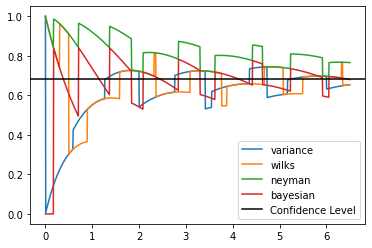

In [14]:
mus = np.linspace(0, 6.5, 1_000)

for func in (inside_variance, inside_wilks, inside_neyman, inside_bayesian):
    label = func.__name__.removeprefix("inside_")
    
    plt.plot(mus, prob_inside(mus, func), label=label)

plt.axhline(CL, color="k", label="Confidence Level")
plt.legend()
plt.show()

A diferencia de las distribuciones continuas, estas reglas no tienen exactamente la cobertura pedida en el caso de las distribuciones discretas. La única de estas reglas que nunca subestima la cobertura es el caso del intervalo frecuentista exacto (neyman).